In [1]:
import random
import os
import os.path as osp
import re
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import find_peaks
import seaborn as sns
import pickle
import torch
import glob
from scipy.stats import entropy

pd.set_option('display.expand_frame_repr', False)  # DataFrameを改行せずに表示
pd.set_option('display.max_columns', None)  # すべての列を表示

In [2]:
def extract_finalQP(filename):
    match = re.search(r'2ndQP(\d+)', filename)
    if match:
        return int(match.group(1))
    
    match = re.search(r'1stQP(\d+)', filename)
    if match:
        return int(match.group(1))
    
    return None


def extract_1stQP(filename):
    match = re.search(r'1stQP(\d+)', filename)
    if match:
        return int(match.group(1))
    
    return None


def ratio_double_compressed(mean_difference, final_QP):
    # mean_difference = mean_difference[0]
    # final_QP = final_QP[0]
    clamped_mean_difference = np.maximum(mean_difference, -0.01)
    
    #全体のエネルギーを計算
    energy = np.sum(np.square(clamped_mean_difference))
    # energy = np.sum(np.square(mean_difference))
    
    #QP2より右側のエネルギーを計算
    right_energy = np.sum(np.square(clamped_mean_difference[final_QP+1:52]))

        
    # エネルギー比を計算して閾値と比較
    if energy > 0:
        return right_energy / energy
    
    else:
        return 0

    
def is_double_compressed(mean_difference, final_QP, threshold):
    mean_difference = mean_difference[0]
    final_QP = final_QP[0]
    clamped_mean_difference = np.maximum(mean_difference, -0.01)
    
    #全体のエネルギーを計算
    energy = np.sum(np.square(clamped_mean_difference))
    # energy = np.sum(np.square(mean_difference))
    
    #QP2より右側のエネルギーを計算
    right_energy = np.sum(np.square(clamped_mean_difference[final_QP+1:52]))
    # right_energy = np.sum(np.square(mean_difference[final_QP+1:52]))
    
    # print('energy: ', energy)
    # print('R-energy: ', right_energy)
    # print('Ratio: ', right_energy / energy)
    
    
    # エネルギー比を計算して閾値と比較
    if energy <= 0:
        return -1
    
    elif (right_energy / energy) != 0 and (right_energy / energy) > threshold:
        return True
    
    elif (right_energy / energy) != 0 and (right_energy / energy) <= threshold:
        return False
    
    else:
        return -1

def calculate_mae(file_path):
    try:
        with open(file_path, 'rb') as file:
            loaded_data, loaded_data_shifted = pickle.load(file)
    except Exception as e:
        print(f"Error occurred while loading {file_path}: {e}")
        return None

    # タプル内のリストを抽出
    original_mae = np.array(loaded_data)
    shifted_mae = np.array(loaded_data_shifted)

    # Coding ghostを計算してリストに格納する
    mae_difference = shifted_mae - original_mae
    
    # mae_differenceの各要素においてマイナスの値を0に変換
    # mae_difference_positive = np.maximum(mae_difference, 0)
    
    return mae_difference

In [3]:
rootpath_csv = "/Prove/Yoshihisa/HEIF_ghost/HEIF_IMAGES_CSV/"

train_list1 = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30"]

train_list2 = ["31", "32", "33", "34", "35", "36", "37", "38", "39", "40", "41", "42", "43", "44", "45", "46", "47", "48", "49", "50", "51", "52", "53", "54", "55", "56", "57", "58", "59", "60"]

train_list3 = ["61", "62", "63", "64", "65", "66", "67", "68", "69", "70", "71", "72", "73", "74", "75", "76", "77", "78", "79", "80", "81", "82", "83", "84", "85", "86", "87", "88", "89", "90"]

train_list4 = ["91", "92", "93", "94", "95", "96", "97", "98", "99", "100", "101", "102", "103", "104", "105", "106", "107", "108", "109", "110", "111", "112", "113", "114", "115", "116", "117", "118", "119", "120"]

train_list5 = ["121", "122", "123", "124", "125", "126", "127", "128", "129", "130", "131", "132", "133", "134", "135", "136", "137", "138", "139", "140", "141", "142", "143", "144", "145", "146", "147", "148", "149", "150"]

train_list6 = ["151", "152", "153", "154", "155", "156", "157", "158", "159", "160", "161", "162", "163", "164", "165", "166", "167", "168", "169", "170", "171", "172", "173", "174", "175", "176", "177", "178", "179", "180"]

train_list7 = ["181", "182", "183", "184", "185", "186", "187", "188", "189", "190", "191", "192", "193", "194", "195", "196", "197", "198", "199", "200", "201", "202", "203", "204", "205", "206", "207", "208", "209", "210"]

train_list8 = ["211", "212", "213", "214", "215", "216", "217", "218", "219", "220", "221", "222", "223", "224", "225", "226", "227", "228", "229", "230", "231", "232", "233", "234", "235", "236", "237", "238", "239", "240"]

train_list9 = ["241", "242", "243", "244", "245", "246", "247", "248", "249", "250", "251", "252", "253", "254", "255", "256", "257", "258", "259", "260", "261", "262", "263", "264", "265", "266", "267", "268", "269", "270"]

train_list10 = ["271", "272", "273", "274", "275", "276", "277", "278", "279", "280", "281", "282", "283", "284", "285", "286", "287", "288", "289", "290", "291", "292", "293", "294", "295", "296", "297", "298", "299", "300"]


all_train_lists = [train_list1, train_list2, train_list3, train_list4, train_list5,
                   train_list6, train_list7, train_list8, train_list9, train_list10]

# すべてのリストを1つのリストに結合する
combined_train_list = sum(all_train_lists, [])

# リストの順序をランダムにシャッフルする
random.shuffle(combined_train_list)

# シャッフルされたリストを10個のグループに分割する
train_lists = [combined_train_list[i:i+30] for i in range(0, len(combined_train_list), 30)]
print(train_lists)

single_list1 = []
single_list2 = []
single_list3 = []
single_list4 = []
single_list5 = []
single_list6 = []
single_list7 = []
single_list8 = []
single_list9 = []
single_list10 = []

single_recompress_list1 = []
single_recompress_list2 = []
single_recompress_list3 = []
single_recompress_list4 = []
single_recompress_list5 = []
single_recompress_list6 = []
single_recompress_list7 = []
single_recompress_list8 = []
single_recompress_list9 = []
single_recompress_list10 = []

second_largeQP1_list1 = []
second_largeQP1_list2 = []
second_largeQP1_list3 = []
second_largeQP1_list4 = []
second_largeQP1_list5 = []
second_largeQP1_list6 = []
second_largeQP1_list7 = []
second_largeQP1_list8 = []
second_largeQP1_list9 = []
second_largeQP1_list10 = []

second_recompress_largeQP1_list1 = []
second_recompress_largeQP1_list2 = []
second_recompress_largeQP1_list3 = []
second_recompress_largeQP1_list4 = []
second_recompress_largeQP1_list5 = []
second_recompress_largeQP1_list6 = []
second_recompress_largeQP1_list7 = []
second_recompress_largeQP1_list8 = []
second_recompress_largeQP1_list9 = []
second_recompress_largeQP1_list10 = []

second_sameQP_list1 = []
second_sameQP_list2 = []
second_sameQP_list3 = []
second_sameQP_list4 = []
second_sameQP_list5 = []
second_sameQP_list6 = []
second_sameQP_list7 = []
second_sameQP_list8 = []
second_sameQP_list9 = []
second_sameQP_list10 = []

second_recompress_sameQP_list1 = []
second_recompress_sameQP_list2 = []
second_recompress_sameQP_list3 = []
second_recompress_sameQP_list4 = []
second_recompress_sameQP_list5 = []
second_recompress_sameQP_list6 = []
second_recompress_sameQP_list7 = []
second_recompress_sameQP_list8 = []
second_recompress_sameQP_list9 = []
second_recompress_sameQP_list10 = []

second_largeQP2_list1 = []
second_largeQP2_list2 = []
second_largeQP2_list3 = []
second_largeQP2_list4 = []
second_largeQP2_list5 = []
second_largeQP2_list6 = []
second_largeQP2_list7 = []
second_largeQP2_list8 = []
second_largeQP2_list9 = []
second_largeQP2_list10 = []

second_recompress_largeQP2_list1 = []
second_recompress_largeQP2_list2 = []
second_recompress_largeQP2_list3 = []
second_recompress_largeQP2_list4 = []
second_recompress_largeQP2_list5 = []
second_recompress_largeQP2_list6 = []
second_recompress_largeQP2_list7 = []
second_recompress_largeQP2_list8 = []
second_recompress_largeQP2_list9 = []
second_recompress_largeQP2_list10 = []


[['50', '278', '166', '251', '47', '141', '249', '281', '113', '238', '88', '233', '215', '35', '267', '186', '258', '97', '45', '107', '165', '112', '60', '85', '133', '283', '299', '15', '284', '276'], ['115', '270', '26', '236', '255', '244', '91', '5', '76', '98', '110', '288', '295', '271', '135', '93', '33', '69', '232', '138', '256', '44', '169', '120', '268', '22', '204', '205', '221', '257'], ['27', '43', '213', '8', '84', '62', '158', '23', '248', '290', '263', '32', '162', '59', '144', '297', '172', '58', '253', '106', '12', '114', '231', '1', '200', '171', '116', '77', '117', '72'], ['176', '265', '155', '177', '208', '194', '16', '48', '280', '6', '275', '191', '125', '153', '226', '180', '30', '75', '101', '46', '105', '42', '168', '139', '34', '67', '152', '132', '90', '187'], ['19', '279', '121', '161', '287', '9', '54', '124', '212', '156', '250', '292', '74', '65', '291', '151', '298', '235', '222', '86', '264', '170', '68', '269', '118', '24', '10', '179', '129', '19

In [4]:
def process_train_lists(train_list, single_list, single_recompress_list, 
                        second_largeQP1_list, second_recompress_largeQP1_list, 
                        second_sameQP_list, second_recompress_sameQP_list,
                        second_largeQP2_list, second_recompress_largeQP2_list):
    
    for image in train_list:
        single_path = osp.join(rootpath_csv+f'HEIF_images_single_csv/{image}_*')
        single_recompress_path = osp.join(rootpath_csv+f'HEIF_images_second_sameQP_csv/{image}_*')
        
        second_largeQP1_path = osp.join(rootpath_csv+f'HEIF_images_second_csv/{image}_*')
        second_recompress_largeQP1_path = osp.join(rootpath_csv+f'HEIF_images_triple_csv/{image}_*')
        
        second_sameQP_path = osp.join(rootpath_csv+f'HEIF_images_second_sameQP_csv/{image}_*')
        second_recompress_sameQP_path = osp.join(rootpath_csv+f'HEIF_images_triple_sameQP_csv/{image}_*')
        
        second_largeQP2_path = osp.join(rootpath_csv+f'HEIF_images_second_largeQP_csv/{image}_*')
        second_recompress_largeQP2_path = osp.join(rootpath_csv+f'HEIF_images_triple_largeQP_csv/{image}_*')
        

        for path in sorted(glob.glob(single_path)):
            single_list.append(path)
        for path in sorted(glob.glob(single_recompress_path)):
            single_recompress_list.append(path)
            
        for path in sorted(glob.glob(second_largeQP1_path)):
            second_largeQP1_list.append(path)
        for path in sorted(glob.glob(second_recompress_largeQP1_path)):
            second_recompress_largeQP1_list.append(path)
                
        for path in sorted(glob.glob(second_sameQP_path)):
            second_sameQP_list.append(path)
        for path in sorted(glob.glob(second_recompress_sameQP_path)):
            second_recompress_sameQP_list.append(path)
            
        for path in sorted(glob.glob(second_largeQP2_path)):
            second_largeQP2_list.append(path)
        for path in sorted(glob.glob(second_recompress_largeQP2_path)):
            second_recompress_largeQP2_list.append(path)
            

# train_lists = [train_list1, train_list2, train_list3, train_list4, train_list5, train_list6, train_list7, train_list8, train_list9, train_list10]

single_lists = [single_list1, single_list2,
                single_list3, single_list4,
                single_list5, single_list6,
                single_list7, single_list8,
                single_list9, single_list10]

single_recompress_lists = [single_recompress_list1, single_recompress_list2,
                           single_recompress_list3, single_recompress_list4,
                           single_recompress_list5, single_recompress_list6,
                           single_recompress_list7, single_recompress_list8,
                           single_recompress_list9, single_recompress_list10]


second_largeQP1_lists = [second_largeQP1_list1, second_largeQP1_list2,
                        second_largeQP1_list3, second_largeQP1_list4,
                        second_largeQP1_list5, second_largeQP1_list6,
                        second_largeQP1_list7, second_largeQP1_list8,
                        second_largeQP1_list9, second_largeQP1_list10]

second_recompress_largeQP1_lists = [second_recompress_largeQP1_list1, second_recompress_largeQP1_list2,
                           second_recompress_largeQP1_list3, second_recompress_largeQP1_list4,
                           second_recompress_largeQP1_list5, second_recompress_largeQP1_list6,
                           second_recompress_largeQP1_list7, second_recompress_largeQP1_list8,
                           second_recompress_largeQP1_list9, second_recompress_largeQP1_list10]


second_sameQP_lists = [second_sameQP_list1, second_sameQP_list2,
                        second_sameQP_list3, second_sameQP_list4,
                        second_sameQP_list5, second_sameQP_list6,
                        second_sameQP_list7, second_sameQP_list8,
                        second_sameQP_list9, second_sameQP_list10]

second_recompress_sameQP_lists = [second_recompress_sameQP_list1, second_recompress_sameQP_list2,
                           second_recompress_sameQP_list3, second_recompress_sameQP_list4,
                           second_recompress_sameQP_list5, second_recompress_sameQP_list6,
                           second_recompress_sameQP_list7, second_recompress_sameQP_list8,
                           second_recompress_sameQP_list9, second_recompress_sameQP_list10]


second_largeQP2_lists = [second_largeQP2_list1, second_largeQP2_list2,
                        second_largeQP2_list3, second_largeQP2_list4,
                        second_largeQP2_list5, second_largeQP2_list6,
                        second_largeQP2_list7, second_largeQP2_list8,
                        second_largeQP2_list9, second_largeQP2_list10]

second_recompress_largeQP2_lists = [second_recompress_largeQP2_list1, second_recompress_largeQP2_list2,
                           second_recompress_largeQP2_list3, second_recompress_largeQP2_list4,
                           second_recompress_largeQP2_list5, second_recompress_largeQP2_list6,
                           second_recompress_largeQP2_list7, second_recompress_largeQP2_list8,
                           second_recompress_largeQP2_list9, second_recompress_largeQP2_list10]



for train_list, single_list, single_recompress_list, second_largeQP1_list, second_recompress_largeQP1_list, second_sameQP_list, second_recompress_sameQP_list, second_largeQP2_list, second_recompress_largeQP2_list in zip(train_lists, 
                                                                                                                                                                                                                           single_lists,
                                                                                                                                                                                                                           single_recompress_lists,
                                                                                                                                                                                                                           second_largeQP1_lists,
                                                                                                                                                                                                                           second_recompress_largeQP1_lists,
                                                                                                                                                                                                                           second_sameQP_lists,
                                                                                                                                                                                                                           second_recompress_sameQP_lists,
                                                                                                                                                                                                                           second_largeQP2_lists,
                                                                                                                                                                                                                           second_recompress_largeQP2_lists
                                                                                                                                                                                                                          ):
    process_train_lists(train_list, single_list, single_recompress_list, 
                        second_largeQP1_list, second_recompress_largeQP1_list, 
                        second_sameQP_list, second_recompress_sameQP_list,
                        second_largeQP2_list, second_recompress_largeQP2_list)


In [5]:
# print(len(single_lists[6]))
# print(len(single_recompress_lists[6]))
# print(len(second_largeQP1_lists[6]))
# print(len(second_recompress_largeQP1_lists[6]))
# print(len(second_sameQP_lists[6]))
# print(len(second_recompress_sameQP_lists[6]))
# print(len(second_largeQP2_lists[6]))
# print(len(second_recompress_largeQP2_lists[6]))

In [6]:
single_list1 = []
single_list2 = []
single_list3 = []
single_list4 = []
single_list5 = []
single_list6 = []
single_list7 = []
single_list8 = []
single_list9 = []
single_list10 = []

single_recompress_list1 = []
single_recompress_list2 = []
single_recompress_list3 = []
single_recompress_list4 = []
single_recompress_list5 = []
single_recompress_list6 = []
single_recompress_list7 = []
single_recompress_list8 = []
single_recompress_list9 = []
single_recompress_list10 = []

second_largeQP1_list1 = []
second_largeQP1_list2 = []
second_largeQP1_list3 = []
second_largeQP1_list4 = []
second_largeQP1_list5 = []
second_largeQP1_list6 = []
second_largeQP1_list7 = []
second_largeQP1_list8 = []
second_largeQP1_list9 = []
second_largeQP1_list10 = []

second_recompress_largeQP1_list1 = []
second_recompress_largeQP1_list2 = []
second_recompress_largeQP1_list3 = []
second_recompress_largeQP1_list4 = []
second_recompress_largeQP1_list5 = []
second_recompress_largeQP1_list6 = []
second_recompress_largeQP1_list7 = []
second_recompress_largeQP1_list8 = []
second_recompress_largeQP1_list9 = []
second_recompress_largeQP1_list10 = []

second_sameQP_list1 = []
second_sameQP_list2 = []
second_sameQP_list3 = []
second_sameQP_list4 = []
second_sameQP_list5 = []
second_sameQP_list6 = []
second_sameQP_list7 = []
second_sameQP_list8 = []
second_sameQP_list9 = []
second_sameQP_list10 = []

second_recompress_sameQP_list1 = []
second_recompress_sameQP_list2 = []
second_recompress_sameQP_list3 = []
second_recompress_sameQP_list4 = []
second_recompress_sameQP_list5 = []
second_recompress_sameQP_list6 = []
second_recompress_sameQP_list7 = []
second_recompress_sameQP_list8 = []
second_recompress_sameQP_list9 = []
second_recompress_sameQP_list10 = []

second_largeQP2_list1 = []
second_largeQP2_list2 = []
second_largeQP2_list3 = []
second_largeQP2_list4 = []
second_largeQP2_list5 = []
second_largeQP2_list6 = []
second_largeQP2_list7 = []
second_largeQP2_list8 = []
second_largeQP2_list9 = []
second_largeQP2_list10 = []

second_recompress_largeQP2_list1 = []
second_recompress_largeQP2_list2 = []
second_recompress_largeQP2_list3 = []
second_recompress_largeQP2_list4 = []
second_recompress_largeQP2_list5 = []
second_recompress_largeQP2_list6 = []
second_recompress_largeQP2_list7 = []
second_recompress_largeQP2_list8 = []
second_recompress_largeQP2_list9 = []
second_recompress_largeQP2_list10 = []

In [7]:
rootpath_pkl = "/Prove/Yoshihisa/HEIF_ghost/PKL/"


def process_train_lists2(train_list, single_list, single_recompress_list, 
                        second_largeQP1_list, second_recompress_largeQP1_list, 
                        second_sameQP_list, second_recompress_sameQP_list,
                        second_largeQP2_list, second_recompress_largeQP2_list):
    
    for image in train_list:
        single_path = osp.join(rootpath_pkl+f'pkl_single/{image}_*')
        single_recompress_path = osp.join(rootpath_pkl+f'pkl_second_sameQP/{image}_*')
        
        second_largeQP1_path = osp.join(rootpath_pkl+f'pkl_second/{image}_*')
        second_recompress_largeQP1_path = osp.join(rootpath_pkl+f'pkl_triple/{image}_*')
        
        second_sameQP_path = osp.join(rootpath_pkl+f'pkl_second_sameQP/{image}_*')
        second_recompress_sameQP_path = osp.join(rootpath_pkl+f'pkl_triple_sameQP/{image}_*')
        
        second_largeQP2_path = osp.join(rootpath_pkl+f'pkl_second_largeQP/{image}_*')
        second_recompress_largeQP2_path = osp.join(rootpath_pkl+f'pkl_triple_largeQP/{image}_*')
        

        for path in sorted(glob.glob(single_path)):
            single_list.append(path)
        for path in sorted(glob.glob(single_recompress_path)):
            single_recompress_list.append(path)
            
        for path in sorted(glob.glob(second_largeQP1_path)):
            second_largeQP1_list.append(path)
        for path in sorted(glob.glob(second_recompress_largeQP1_path)):
            second_recompress_largeQP1_list.append(path)
                
        for path in sorted(glob.glob(second_sameQP_path)):
            second_sameQP_list.append(path)
        for path in sorted(glob.glob(second_recompress_sameQP_path)):
            second_recompress_sameQP_list.append(path)
            
        for path in sorted(glob.glob(second_largeQP2_path)):
            second_largeQP2_list.append(path)
        for path in sorted(glob.glob(second_recompress_largeQP2_path)):
            second_recompress_largeQP2_list.append(path)
            

# train_lists = [train_list1, train_list2, train_list3, train_list4, train_list5, train_list6, train_list7, train_list8, train_list9, train_list10]

single_listsA = [single_list1, single_list2,
                single_list3, single_list4,
                single_list5, single_list6,
                single_list7, single_list8,
                single_list9, single_list10]

single_recompress_listsA = [single_recompress_list1, single_recompress_list2,
                           single_recompress_list3, single_recompress_list4,
                           single_recompress_list5, single_recompress_list6,
                           single_recompress_list7, single_recompress_list8,
                           single_recompress_list9, single_recompress_list10]


second_largeQP1_listsA = [second_largeQP1_list1, second_largeQP1_list2,
                        second_largeQP1_list3, second_largeQP1_list4,
                        second_largeQP1_list5, second_largeQP1_list6,
                        second_largeQP1_list7, second_largeQP1_list8,
                        second_largeQP1_list9, second_largeQP1_list10]

second_recompress_largeQP1_listsA = [second_recompress_largeQP1_list1, second_recompress_largeQP1_list2,
                           second_recompress_largeQP1_list3, second_recompress_largeQP1_list4,
                           second_recompress_largeQP1_list5, second_recompress_largeQP1_list6,
                           second_recompress_largeQP1_list7, second_recompress_largeQP1_list8,
                           second_recompress_largeQP1_list9, second_recompress_largeQP1_list10]


second_sameQP_listsA = [second_sameQP_list1, second_sameQP_list2,
                        second_sameQP_list3, second_sameQP_list4,
                        second_sameQP_list5, second_sameQP_list6,
                        second_sameQP_list7, second_sameQP_list8,
                        second_sameQP_list9, second_sameQP_list10]

second_recompress_sameQP_listsA = [second_recompress_sameQP_list1, second_recompress_sameQP_list2,
                           second_recompress_sameQP_list3, second_recompress_sameQP_list4,
                           second_recompress_sameQP_list5, second_recompress_sameQP_list6,
                           second_recompress_sameQP_list7, second_recompress_sameQP_list8,
                           second_recompress_sameQP_list9, second_recompress_sameQP_list10]


second_largeQP2_listsA = [second_largeQP2_list1, second_largeQP2_list2,
                        second_largeQP2_list3, second_largeQP2_list4,
                        second_largeQP2_list5, second_largeQP2_list6,
                        second_largeQP2_list7, second_largeQP2_list8,
                        second_largeQP2_list9, second_largeQP2_list10]

second_recompress_largeQP2_listsA = [second_recompress_largeQP2_list1, second_recompress_largeQP2_list2,
                           second_recompress_largeQP2_list3, second_recompress_largeQP2_list4,
                           second_recompress_largeQP2_list5, second_recompress_largeQP2_list6,
                           second_recompress_largeQP2_list7, second_recompress_largeQP2_list8,
                           second_recompress_largeQP2_list9, second_recompress_largeQP2_list10]



for train_list, single_list, single_recompress_list, second_largeQP1_list, second_recompress_largeQP1_list, second_sameQP_list, second_recompress_sameQP_list, second_largeQP2_list, second_recompress_largeQP2_list in zip(train_lists, 
                                                                                                                                                                                                                           single_listsA,
                                                                                                                                                                                                                           single_recompress_listsA,
                                                                                                                                                                                                                           second_largeQP1_listsA,
                                                                                                                                                                                                                           second_recompress_largeQP1_listsA,
                                                                                                                                                                                                                           second_sameQP_listsA,
                                                                                                                                                                                                                           second_recompress_sameQP_listsA,
                                                                                                                                                                                                                           second_largeQP2_listsA,
                                                                                                                                                                                                                           second_recompress_largeQP2_listsA
                                                                                                                                                                                                                          ):
    process_train_lists2(train_list, single_list, single_recompress_list, 
                        second_largeQP1_list, second_recompress_largeQP1_list, 
                        second_sameQP_list, second_recompress_sameQP_list,
                        second_largeQP2_list, second_recompress_largeQP2_list)

In [8]:
# print(len(single_listsA[6]))
# print(len(single_recompress_listsA[6]))
# print(len(second_largeQP1_listsA[6]))
# print(len(second_recompress_largeQP1_listsA[6]))
# print(len(second_sameQP_listsA[6]))
# print(len(second_recompress_sameQP_listsA[6]))
# print(len(second_largeQP2_listsA[6]))
# print(len(second_recompress_largeQP2_listsA[6]))

In [9]:
single_csv1 = list(zip(single_lists[0], single_listsA[0], single_recompress_lists[0], single_recompress_listsA[0]))
single_csv2 = list(zip(single_lists[1], single_listsA[1], single_recompress_lists[1], single_recompress_listsA[1]))
single_csv3 = list(zip(single_lists[2], single_listsA[2], single_recompress_lists[2], single_recompress_listsA[2]))
single_csv4 = list(zip(single_lists[3], single_listsA[3], single_recompress_lists[3], single_recompress_listsA[3]))
single_csv5 = list(zip(single_lists[4], single_listsA[4], single_recompress_lists[4], single_recompress_listsA[4]))
single_csv6 = list(zip(single_lists[5], single_listsA[5], single_recompress_lists[5], single_recompress_listsA[5]))
single_csv7 = list(zip(single_lists[6], single_listsA[6], single_recompress_lists[6], single_recompress_listsA[6]))
single_csv8 = list(zip(single_lists[7], single_listsA[7], single_recompress_lists[7], single_recompress_listsA[7]))
single_csv9 = list(zip(single_lists[8], single_listsA[8], single_recompress_lists[8], single_recompress_listsA[8]))
single_csv10 = list(zip(single_lists[9], single_listsA[9], single_recompress_lists[9], single_recompress_listsA[9]))
# print(len(single_csv7))

second_largeQP1_csv1 = list(zip(second_largeQP1_lists[0], second_largeQP1_listsA[0], second_recompress_largeQP1_lists[0], second_recompress_largeQP1_listsA[0]))
second_largeQP1_csv2 = list(zip(second_largeQP1_lists[1], second_largeQP1_listsA[1], second_recompress_largeQP1_lists[1], second_recompress_largeQP1_listsA[1]))
second_largeQP1_csv3 = list(zip(second_largeQP1_lists[2], second_largeQP1_listsA[2], second_recompress_largeQP1_lists[2], second_recompress_largeQP1_listsA[2]))
second_largeQP1_csv4 = list(zip(second_largeQP1_lists[3], second_largeQP1_listsA[3], second_recompress_largeQP1_lists[3], second_recompress_largeQP1_listsA[3]))
second_largeQP1_csv5 = list(zip(second_largeQP1_lists[4], second_largeQP1_listsA[4], second_recompress_largeQP1_lists[4], second_recompress_largeQP1_listsA[4]))
second_largeQP1_csv6 = list(zip(second_largeQP1_lists[5], second_largeQP1_listsA[5], second_recompress_largeQP1_lists[5], second_recompress_largeQP1_listsA[5]))
second_largeQP1_csv7 = list(zip(second_largeQP1_lists[6], second_largeQP1_listsA[6], second_recompress_largeQP1_lists[6], second_recompress_largeQP1_listsA[6]))
second_largeQP1_csv8 = list(zip(second_largeQP1_lists[7], second_largeQP1_listsA[7], second_recompress_largeQP1_lists[7], second_recompress_largeQP1_listsA[7]))
second_largeQP1_csv9 = list(zip(second_largeQP1_lists[8], second_largeQP1_listsA[8], second_recompress_largeQP1_lists[8], second_recompress_largeQP1_listsA[8]))
second_largeQP1_csv10 = list(zip(second_largeQP1_lists[9], second_largeQP1_listsA[9], second_recompress_largeQP1_lists[9], second_recompress_largeQP1_listsA[9]))

second_largeQP1_csv1 = random.sample(second_largeQP1_csv1, 100)
second_largeQP1_csv2 = random.sample(second_largeQP1_csv2, 100)
second_largeQP1_csv3 = random.sample(second_largeQP1_csv3, 100)
second_largeQP1_csv4 = random.sample(second_largeQP1_csv4, 100)
second_largeQP1_csv5 = random.sample(second_largeQP1_csv5, 100)
second_largeQP1_csv6 = random.sample(second_largeQP1_csv6, 100)
second_largeQP1_csv7 = random.sample(second_largeQP1_csv7, 100)
second_largeQP1_csv8 = random.sample(second_largeQP1_csv8, 100)
second_largeQP1_csv9 = random.sample(second_largeQP1_csv9, 100)
second_largeQP1_csv10 = random.sample(second_largeQP1_csv10, 300)
# print(len(second_largeQP1_csv1))
# print(len(second_largeQP1_csv10))

second_sameQP_csv1 = list(zip(second_sameQP_lists[0], second_sameQP_listsA[0], second_recompress_sameQP_lists[0], second_recompress_sameQP_listsA[0]))
second_sameQP_csv2 = list(zip(second_sameQP_lists[1], second_sameQP_listsA[1], second_recompress_sameQP_lists[1], second_recompress_sameQP_listsA[1]))
second_sameQP_csv3 = list(zip(second_sameQP_lists[2], second_sameQP_listsA[2], second_recompress_sameQP_lists[2], second_recompress_sameQP_listsA[2]))
second_sameQP_csv4 = list(zip(second_sameQP_lists[3], second_sameQP_listsA[3], second_recompress_sameQP_lists[3], second_recompress_sameQP_listsA[3]))
second_sameQP_csv5 = list(zip(second_sameQP_lists[4], second_sameQP_listsA[4], second_recompress_sameQP_lists[4], second_recompress_sameQP_listsA[4]))
second_sameQP_csv6 = list(zip(second_sameQP_lists[5], second_sameQP_listsA[5], second_recompress_sameQP_lists[5], second_recompress_sameQP_listsA[5]))
second_sameQP_csv7 = list(zip(second_sameQP_lists[6], second_sameQP_listsA[6], second_recompress_sameQP_lists[6], second_recompress_sameQP_listsA[6]))
second_sameQP_csv8 = list(zip(second_sameQP_lists[7], second_sameQP_listsA[7], second_recompress_sameQP_lists[7], second_recompress_sameQP_listsA[7]))
second_sameQP_csv9 = list(zip(second_sameQP_lists[8], second_sameQP_listsA[8], second_recompress_sameQP_lists[8], second_recompress_sameQP_listsA[8]))
second_sameQP_csv10 = list(zip(second_sameQP_lists[9], second_sameQP_listsA[9], second_recompress_sameQP_lists[9], second_recompress_sameQP_listsA[9]))

second_sameQP_csv1 = random.sample(second_sameQP_csv1, 100)
second_sameQP_csv2 = random.sample(second_sameQP_csv2, 100)
second_sameQP_csv3 = random.sample(second_sameQP_csv3, 100)
second_sameQP_csv4 = random.sample(second_sameQP_csv4, 100)
second_sameQP_csv5 = random.sample(second_sameQP_csv5, 100)
second_sameQP_csv6 = random.sample(second_sameQP_csv6, 100)
second_sameQP_csv7 = random.sample(second_sameQP_csv7, 100)
second_sameQP_csv8 = random.sample(second_sameQP_csv8, 100)
second_sameQP_csv9 = random.sample(second_sameQP_csv9, 100)
second_sameQP_csv10 = random.sample(second_sameQP_csv10, 300)
# print(len(second_sameQP_csv1))
# print(len(second_sameQP_csv10))

second_largeQP2_csv1 = list(zip(second_largeQP2_lists[0], second_largeQP2_listsA[0], second_recompress_largeQP2_lists[0], second_recompress_largeQP2_listsA[0]))
second_largeQP2_csv2 = list(zip(second_largeQP2_lists[1], second_largeQP2_listsA[1], second_recompress_largeQP2_lists[1], second_recompress_largeQP2_listsA[1]))
second_largeQP2_csv3 = list(zip(second_largeQP2_lists[2], second_largeQP2_listsA[2], second_recompress_largeQP2_lists[2], second_recompress_largeQP2_listsA[2]))
second_largeQP2_csv4 = list(zip(second_largeQP2_lists[3], second_largeQP2_listsA[3], second_recompress_largeQP2_lists[3], second_recompress_largeQP2_listsA[3]))
second_largeQP2_csv5 = list(zip(second_largeQP2_lists[4], second_largeQP2_listsA[4], second_recompress_largeQP2_lists[4], second_recompress_largeQP2_listsA[4]))
second_largeQP2_csv6 = list(zip(second_largeQP2_lists[5], second_largeQP2_listsA[5], second_recompress_largeQP2_lists[5], second_recompress_largeQP2_listsA[5]))
second_largeQP2_csv7 = list(zip(second_largeQP2_lists[6], second_largeQP2_listsA[6], second_recompress_largeQP2_lists[6], second_recompress_largeQP2_listsA[6]))
second_largeQP2_csv8 = list(zip(second_largeQP2_lists[7], second_largeQP2_listsA[7], second_recompress_largeQP2_lists[7], second_recompress_largeQP2_listsA[7]))
second_largeQP2_csv9 = list(zip(second_largeQP2_lists[8], second_largeQP2_listsA[8], second_recompress_largeQP2_lists[8], second_recompress_largeQP2_listsA[8]))
second_largeQP2_csv10 = list(zip(second_largeQP2_lists[9], second_largeQP2_listsA[9], second_recompress_largeQP2_lists[9], second_recompress_largeQP2_listsA[9]))

second_largeQP2_csv1 = random.sample(second_largeQP2_csv1, 100)
second_largeQP2_csv2 = random.sample(second_largeQP2_csv2, 100)
second_largeQP2_csv3 = random.sample(second_largeQP2_csv3, 100)
second_largeQP2_csv4 = random.sample(second_largeQP2_csv4, 100)
second_largeQP2_csv5 = random.sample(second_largeQP2_csv5, 100)
second_largeQP2_csv6 = random.sample(second_largeQP2_csv6, 100)
second_largeQP2_csv7 = random.sample(second_largeQP2_csv7, 100)
second_largeQP2_csv8 = random.sample(second_largeQP2_csv8, 100)
second_largeQP2_csv9 = random.sample(second_largeQP2_csv9, 100)
second_largeQP2_csv10 = random.sample(second_largeQP2_csv10, 300)
# print(len(second_largeQP2_csv1))
# print(len(second_largeQP2_csv10))


train_csv_list1 = single_csv1 + second_largeQP1_csv1 + second_sameQP_csv1 + second_largeQP2_csv1
train_csv_list2 = single_csv2 + second_largeQP1_csv2 + second_sameQP_csv2 + second_largeQP2_csv2
train_csv_list3 = single_csv3 + second_largeQP1_csv3 + second_sameQP_csv3 + second_largeQP2_csv3
train_csv_list4 = single_csv4 + second_largeQP1_csv4 + second_sameQP_csv4 + second_largeQP2_csv4
train_csv_list5 = single_csv5 + second_largeQP1_csv5 + second_sameQP_csv5 + second_largeQP2_csv5
train_csv_list6 = single_csv6 + second_largeQP1_csv6 + second_sameQP_csv6 + second_largeQP2_csv6
train_csv_list7 = single_csv7 + second_largeQP1_csv7 + second_sameQP_csv7 + second_largeQP2_csv7
train_csv_list8 = single_csv8 + second_largeQP1_csv8 + second_sameQP_csv8 + second_largeQP2_csv8
train_csv_list9 = single_csv9 + second_largeQP1_csv9 + second_sameQP_csv9 + second_largeQP2_csv9
print("train_csv_list: ", len(train_csv_list1))

test_csv_largeQP1 = single_csv10 + second_largeQP1_csv10
test_csv_sameQP = single_csv10 + second_sameQP_csv10
test_csv_largeQP2 = single_csv10 + second_largeQP2_csv10

print("test_csv_largeQP1", len(test_csv_largeQP1))
print("test_csv_sameQP", len(test_csv_sameQP))
print("test_csv_largeQP2", len(test_csv_largeQP2))

train_csv_list:  600
test_csv_largeQP1 600
test_csv_sameQP 600
test_csv_largeQP2 600


In [10]:
def laplace_smoothing(probabilities, alpha=1):
    """
    ラプラス平滑化を行う関数
    
    Args:
    probabilities (list): 平滑化する確率分布のリスト
    alpha (float): 平滑化パラメータ
    
    Returns:
    smoothed_probabilities (list): 平滑化された確率分布のリスト
    """
    total_count = sum(probabilities)
    num_elements = len(probabilities)
    
    smoothed_probabilities = [(count + alpha) / (total_count + alpha * num_elements) for count in probabilities]
    
    return smoothed_probabilities


def process_train_csv_lists(train_csv_list):
    
    pu_columns = ["PU1_64", "PU1_32", "PU1_16", "PU1_8", "PU1_4",  
                  "PU2_64","PU2_32", "PU2_16", "PU2_8", "PU2_4"]

#     luminance_columns = ["LU1_0","LU1_1","LU1_2","LU1_3",
#                          "LU1_4","LU1_5","LU1_6","LU1_7",
#                          "LU1_8","LU1_9","LU1_10","LU1_11",
#                          "LU1_12","LU1_13","LU1_14","LU1_15",
#                          "LU1_16","LU1_17","LU1_18","LU1_19",
#                          "LU1_20","LU1_21","LU1_22","LU1_23",
#                          "LU1_24","LU1_25","LU1_26","LU1_27",
#                          "LU1_28","LU1_29","LU1_30","LU1_31",
#                          "LU1_32","LU1_33","LU1_34",
                         
#                          "LU2_0","LU2_1","LU2_2","LU2_3",
#                          "LU2_4","LU2_5","LU2_6","LU2_7",
#                          "LU2_8","LU2_9","LU2_10","LU2_11",
#                          "LU2_12","LU2_13","LU2_14","LU2_15",
#                          "LU2_16","LU2_17","LU2_18","LU2_19",
#                          "LU2_20","LU2_21","LU2_22","LU2_23",
#                          "LU2_24","LU2_25","LU2_26","LU2_27",
#                          "LU2_28","LU2_29","LU2_30","LU2_31",
#                          "LU2_32","LU2_33","LU2_34"]
    
    luminance_columns = ["LU1_0","LU1_1","LU1_9","LU1_10","LU1_11","LU1_25","LU1_26","LU1_27",
                         "LU2_0","LU2_1","LU2_9","LU2_10","LU2_11", "LU2_25","LU2_26","LU2_27"]

    chrominance_columns = ["CH1_0", "CH1_1", "CH1_10", "CH1_26", "CH1_34", "CH1_36", 
                           "CH2_0", "CH2_1", "CH2_10", "CH2_26", "CH2_34", "CH2_36"]

    label_columns = ["LABEL"]
    mae1_columns = [f"MAE1_{i}" for i in range(52)]
    mae2_columns = [f"MAE2_{i}" for i in range(52)]
    mae_columns = ["MAE"]
    final_qp_columns = ["FINAL_QP"]
    kl_divergence1 = ["KLD_PU"]
    kl_divergence2 = ["KLD_LUMA"]
    kl_divergence3 = ["KLD_CHROMA"]
    ratio_columns1 = ["RATIO1"]
    ratio_columns2 = ["RATIO2"]


    train_df1_1 = pd.DataFrame(columns=pu_columns)
    train_df1_2 = pd.DataFrame(columns=luminance_columns)
    train_df1_3 = pd.DataFrame(columns=chrominance_columns)
    LABEL = pd.DataFrame(columns=label_columns)
    RATIO1 = pd.DataFrame(columns=ratio_columns1)
    RATIO2 = pd.DataFrame(columns=ratio_columns2)
    train_df3 = pd.DataFrame(columns=mae1_columns)
    train_df4 = pd.DataFrame(columns=mae2_columns)
    MAE = pd.DataFrame(columns=mae_columns)
    FINAL_QP = pd.DataFrame(columns=final_qp_columns)
    kl_divergence_df1 = pd.DataFrame(columns=kl_divergence1)
    kl_divergence_df2 = pd.DataFrame(columns=kl_divergence2)
    kl_divergence_df3 = pd.DataFrame(columns=kl_divergence3)

    for path1, path2, path3, path4 in train_csv_list:
        label = 1 if ("2ndQP" in path1) and ("3rdQP" in path3) else 0
        train_pkl_list = [path2, path4]
        df1 = pd.read_csv(path1)
        df2 = pd.read_csv(path3)
        
        
        # 平滑化を行う
        probabilities_df1 = laplace_smoothing([df1.loc[i, "pu_counts"] for i in [0,1,2,3,4]])
        probabilities_df2 = laplace_smoothing([df2.loc[i, "pu_counts"] for i in [0,1,2,3,4]])
        kl_divergence1 = entropy(probabilities_df1, probabilities_df2)
        
        probabilities_df3 = laplace_smoothing([df1.loc[i, "luminance_counts"] for i in [0,1,9,10,11,25,26,27]])
        probabilities_df4 = laplace_smoothing([df2.loc[i, "luminance_counts"] for i in [0,1,9,10,11,25,26,27]])
        kl_divergence2 = entropy(probabilities_df3, probabilities_df4)
        
        probabilities_df5 = laplace_smoothing([df1.loc[i, "chroma_counts"] for i in [0,1,10,26,34,36]])
        probabilities_df6 = laplace_smoothing([df2.loc[i, "chroma_counts"] for i in [0,1,10,26,34,36]])
        kl_divergence3 = entropy(probabilities_df5, probabilities_df6)
        
        
        pu_values = [df1.loc[i, "pu_counts"] for i in range(5)] + [df2.loc[i, "pu_counts"] for i in range(5)]
        # lu_values = [df1.loc[i, "luminance_counts"] for i in range(35)] + [df2.loc[i, "luminance_counts"] for i in range(35)]
        lu_values = [df1.loc[i, "luminance_counts"] for i in [0,1,9,10,11,25,26,27]] + [df2.loc[i, "luminance_counts"] for i in [0,1,9,10,11,25,26,27]]
        ch_values = [df1.loc[i, "chroma_counts"] for i in [0,1,10,26,34,36]] + [df2.loc[i, "chroma_counts"] for i in [0,1,10,26,34,36]]
        
        train_df1_1 = pd.concat([train_df1_1, pd.DataFrame([pu_values], columns=pu_columns)], ignore_index=True)
        train_df1_2= pd.concat([train_df1_2, pd.DataFrame([lu_values], columns=luminance_columns)], ignore_index=True)
        train_df1_3 = pd.concat([train_df1_3, pd.DataFrame([ch_values], columns=chrominance_columns)], ignore_index=True)
        
        kl_divergence_df1 = pd.concat([kl_divergence_df1, pd.DataFrame({"KLD_PU": [kl_divergence1]})], ignore_index=True)
        kl_divergence_df2 = pd.concat([kl_divergence_df2, pd.DataFrame({"KLD_LUMA": [kl_divergence2]})], ignore_index=True)
        kl_divergence_df3 = pd.concat([kl_divergence_df3, pd.DataFrame({"KLD_CHROMA": [kl_divergence3]})], ignore_index=True)


        LABEL = pd.concat([LABEL, pd.DataFrame({"LABEL": [label]})], ignore_index=True)
        final_QP = extract_finalQP(train_pkl_list[0])

        mae_d1 = calculate_mae(train_pkl_list[0])
        mae_d2 = calculate_mae(train_pkl_list[1])
        ratio1 = ratio_double_compressed(mae_d1, final_QP)
        ratio2 = ratio_double_compressed(mae_d2, final_QP)

        RATIO1 = pd.concat([RATIO1, pd.DataFrame({"RATIO1": [ratio1]})], ignore_index=True)
        RATIO2 = pd.concat([RATIO2, pd.DataFrame({"RATIO2": [ratio2]})], ignore_index=True)
        

        train_df3 = pd.concat([train_df3, pd.DataFrame({f"MAE1_{i}": [mae_d1[i]] for i in range(52)})], ignore_index=True)
        train_df4 = pd.concat([train_df4, pd.DataFrame({f"MAE2_{i}": [mae_d2[i]] for i in range(52)})], ignore_index=True)
        MAE = pd.concat([MAE, pd.DataFrame({"MAE": [mae_d1]})], ignore_index=True)
        FINAL_QP = pd.concat([FINAL_QP, pd.DataFrame({"FINAL_QP": [final_QP]})], ignore_index=True)

        

    train_df1_1.reset_index(drop=True, inplace=True)
    train_df1_2.reset_index(drop=True, inplace=True)
    train_df1_3.reset_index(drop=True, inplace=True)
    LABEL.reset_index(drop=True, inplace=True)
    RATIO1.reset_index(drop=True, inplace=True)
    RATIO2.reset_index(drop=True, inplace=True)
    kl_divergence_df1.reset_index(drop=True, inplace=True)
    kl_divergence_df2.reset_index(drop=True, inplace=True)
    kl_divergence_df3.reset_index(drop=True, inplace=True)

    # train_df = pd.concat([train_df1_1, train_df1_2, train_df1_3, train_df3, train_df4], axis=1)
    train_df = pd.concat([FINAL_QP, train_df1_1, train_df1_2, train_df1_3, RATIO1, RATIO2], axis=1)
    train_df_onlyGhost = pd.concat([train_df3, train_df4], axis=1)

    return train_df, train_df_onlyGhost, LABEL, MAE, FINAL_QP


In [11]:
train_df1, train_df_onlyGhost1, LABEL1, MAE1, FINAL_QP1 = process_train_csv_lists(train_csv_list1)
train_df2, train_df_onlyGhost2, LABEL2, MAE2, FINAL_QP2 = process_train_csv_lists(train_csv_list2)
train_df3, train_df_onlyGhost3, LABEL3, MAE3, FINAL_QP3 = process_train_csv_lists(train_csv_list3)
train_df4, train_df_onlyGhost4, LABEL4, MAE4, FINAL_QP4 = process_train_csv_lists(train_csv_list4)
train_df5, train_df_onlyGhost5, LABEL5, MAE5, FINAL_QP5 = process_train_csv_lists(train_csv_list5)
train_df6, train_df_onlyGhost6, LABEL6, MAE6, FINAL_QP6 = process_train_csv_lists(train_csv_list6)
train_df7, train_df_onlyGhost7, LABEL7, MAE7, FINAL_QP7 = process_train_csv_lists(train_csv_list7)
train_df8, train_df_onlyGhost8, LABEL8, MAE8, FINAL_QP8 = process_train_csv_lists(train_csv_list8)
train_df9, train_df_onlyGhost9, LABEL9, MAE9, FINAL_QP9 = process_train_csv_lists(train_csv_list9)


test_df1, test_df_onlyGhost1, LABEL_t1, MAE_t1, FINAL_QP_t1 = process_train_csv_lists(test_csv_largeQP1)
test_df2, test_df_onlyGhost2, LABEL_t2, MAE_t2, FINAL_QP_t2 = process_train_csv_lists(test_csv_sameQP)
test_df3, test_df_onlyGhost3, LABEL_t3, MAE_t3, FINAL_QP_t3 = process_train_csv_lists(test_csv_largeQP2)

In [12]:
print(train_df1)

    FINAL_QP PU1_64 PU1_32 PU1_16  PU1_8  PU1_4 PU2_64 PU2_32 PU2_16  PU2_8  PU2_4  LU1_0  LU1_1 LU1_9 LU1_10 LU1_11 LU1_25 LU1_26 LU1_27  LU2_0  LU2_1 LU2_9 LU2_10 LU2_11 LU2_25 LU2_26 LU2_27  CH1_0  CH1_1 CH1_10 CH1_26 CH1_34 CH1_36  CH2_0  CH2_1 CH2_10 CH2_26 CH2_34 CH2_36    RATIO1    RATIO2
0         10      0      0    160   5016  54824      0      0    160   3912  55928   7236   6144  1659   1989   1554   1457   2083   1331   7143   6556  1613   2053   1568   1444   2041   1335  18136  12260   7536   7984   1776  12308  18508  13604   7908   8368   1428  10184  0.159286  0.086845
1         16      0      0    448   7596  51956      0      0    432   6560  53008   6789   6215  1551   2127   1555   1338   2125   1235   6919   6414  1544   2086   1625   1351   2189   1274  18144  12360   6160   6584   1656  15096  17732  14912   6440   6632   1284  13000  0.035875  0.017933
2         20      0      0   1088   9636  49276      0      0   1056   8564  50380   7283   6792  1458   2031

In [13]:
def process_results_to_lists(train_df, train_df_onlyGhost, LABEL, MAE, FINAL_QP):
    scaler = MinMaxScaler()

    # スケーラーを使って結合したデータをスケーリング
    X_train = scaler.fit_transform(train_df)
    X_train_onlyGhost = scaler.fit_transform(train_df_onlyGhost)

    # pandasをndarrayに変換
    MAE_array = MAE.values
    FINAL_QP_array = FINAL_QP.values

    # ラベルの準備
    Y_train = LABEL['LABEL'].astype(int)

    return X_train, X_train_onlyGhost, MAE_array, FINAL_QP_array, Y_train

def append_results_to_lists(train_df, train_df_onlyGhost, LABEL, MAE, FINAL_QP,
                            X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list):
    X_train, X_train_onlyGhost, MAE_array, FINAL_QP_array, Y_train = process_results_to_lists(train_df, train_df_onlyGhost, LABEL, MAE, FINAL_QP)
    X_train_list.append(X_train)
    X_train_onlyGhost_list.append(X_train_onlyGhost)
    MAE_list.append(MAE_array)
    FINAL_QP_list.append(FINAL_QP_array)
    Y_train_list.append(Y_train)

# リストを初期化
X_train_list = []
X_train_onlyGhost_list = []
MAE_list = []
FINAL_QP_list = []
Y_train_list = []

X_test_list1 = []
X_test_onlyGhost_list1 = []
MAE_list_t1 = []
FINAL_QP_list_t1 = []
Y_test_list1 = []

X_test_list2 = []
X_test_onlyGhost_list2 = []
MAE_list_t2 = []
FINAL_QP_list_t2 = []
Y_test_list2 = []

X_test_list3 = []
X_test_onlyGhost_list3 = []
MAE_list_t3 = []
FINAL_QP_list_t3 = []
Y_test_list3 = []


# データを処理してリストに追加
append_results_to_lists(train_df1, train_df_onlyGhost1, LABEL1, MAE1, FINAL_QP1, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)
append_results_to_lists(train_df2, train_df_onlyGhost2, LABEL2, MAE2, FINAL_QP2, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)
append_results_to_lists(train_df3, train_df_onlyGhost3, LABEL3, MAE3, FINAL_QP3, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)
append_results_to_lists(train_df4, train_df_onlyGhost4, LABEL4, MAE4, FINAL_QP4, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)
append_results_to_lists(train_df5, train_df_onlyGhost5, LABEL5, MAE5, FINAL_QP5, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)
append_results_to_lists(train_df6, train_df_onlyGhost6, LABEL6, MAE6, FINAL_QP6, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)
append_results_to_lists(train_df7, train_df_onlyGhost7, LABEL7, MAE7, FINAL_QP7, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)
append_results_to_lists(train_df8, train_df_onlyGhost8, LABEL8, MAE8, FINAL_QP8, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)
append_results_to_lists(train_df9, train_df_onlyGhost9, LABEL9, MAE9, FINAL_QP9, X_train_list, X_train_onlyGhost_list, MAE_list, FINAL_QP_list, Y_train_list)

append_results_to_lists(test_df1, test_df_onlyGhost1, LABEL_t1, MAE_t1, FINAL_QP_t1, X_test_list1, X_test_onlyGhost_list1, MAE_list_t1, FINAL_QP_list_t1, Y_test_list1)
append_results_to_lists(test_df2, test_df_onlyGhost2, LABEL_t2, MAE_t2, FINAL_QP_t2, X_test_list2, X_test_onlyGhost_list2, MAE_list_t2, FINAL_QP_list_t2, Y_test_list2)
append_results_to_lists(test_df3, test_df_onlyGhost3, LABEL_t3, MAE_t3, FINAL_QP_t3, X_test_list3, X_test_onlyGhost_list3, MAE_list_t3, FINAL_QP_list_t3, Y_test_list3)

In [14]:
# 各リストの長さを確認
# print(len(X_train_list))
# print((X_train_onlyGhost_list[0])[0])
# print((MAE_list[0])[0])
# print((FINAL_QP_list[0])[0])
# print((Y_train_list[0])[0])

# print(len(X_test_list1[0]))
# print(len(X_test_onlyGhost_list1[0]))
# print(len(X_test_onlyGhost_list2[0]))
# print(len(X_test_onlyGhost_list3[0]))
# print((MAE_list_t1[0])[0])
# print((FINAL_QP_list_t1[0])[0])
# print((Y_test_list1[0])[0])

In [15]:
# Cの範囲を指定
C_values = {'C': [0.01, 0.1, 1, 10, 100, 1000, 2000, 3000, 4000, 5000]}
# C_values = {'C': [0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]}
# kfold = StratifiedKFold(n_splits=10, shuffle=True)
kfold = KFold(n_splits=9, shuffle=True, random_state=42)


# results = pd.DataFrame(columns=['C_RBF_LQP1','Score_RBF_LQP1', 'tnr_rbf_lqp1', 'tpr_rbf_lqp1',
#                                 'C_RBF_SQP','Score_RBF_SQP', 'tnr_rbf_sqp', 'tpr_rbf_sqp',
#                                 'C_RBF_LQP2','Score_RBF_LQP2', 'tnr_rbf_lqp2', 'tpr_rbf_lqp2',
#                                 'C_LINEAR_LQP1','Score_LINEAR_LQP1', 'tnr_linear_lqp1', 'tpr_linear_lqp1',
#                                 'C_LINEAR_SQP','Score_LINEAR_SQP', 'tnr_linear_sqp', 'tpr_linear_sqp',
#                                 'C_LINEAR_LQP2','Score_LINEAR_LQP2', 'tnr_linear_lqp2', 'tpr_linear_lqp2',
                                
#                                 'C_RBF_OG_LQP1','Score_RBF_OG_LQP1', 'tnr_og_rbf_lqp1', 'tpr_og_rbf_lqp1',
#                                 'C_RBF_OG_SQP','Score_RBF_OG_SQP', 'tnr_og_rbf_sqp', 'tpr_og_rbf_sqp',
#                                 'C_RBF_OG_LQP2','Score_RBF_OG_LQP2', 'tnr_og_rbf_lqp2', 'tpr_og_rbf_lqp2',
#                                 'C_LINEAR_OG_LQP1','Score_LINEAR_OG_LQP1', 'tnr_og_linear_lqp1', 'tpr_og_linear_lqp1',
#                                 'C_LINEAR_OG_SQP','Score_LINEAR_OG_SQP', 'tnr_og_linear_sqp', 'tpr_og_linear_sqp',
#                                 'C_LINEAR_OG_LQP2','Score_LINEAR_OG_LQP2', 'tnr_og_linear_lqp2', 'tpr_og_linear_lqp2',
                                
#                                 'Threshold_LQP1', 'LQP1_old', 'tnr_old_lqp1', 'tpr_old_lqp1',
#                                 'Threshold_SQP', 'SQP_old', 'tnr_old_sqp', 'tpr_old_sqp',
#                                 'Threshold_LQP2', 'LQP2_old', 'tnr_old_lqp2', 'tpr_old_lqp2'])


results = pd.DataFrame(columns=['C_RBF_LQP1','Score_RBF_LQP1', 'tnr_rbf_lqp1', 'tpr_rbf_lqp1',
                                'C_RBF_SQP','Score_RBF_SQP', 'tnr_rbf_sqp', 'tpr_rbf_sqp',
                                'C_RBF_LQP2','Score_RBF_LQP2', 'tnr_rbf_lqp2', 'tpr_rbf_lqp2',
                                'C_LINEAR_LQP1','Score_LINEAR_LQP1', 'tnr_linear_lqp1', 'tpr_linear_lqp1',
                                'C_LINEAR_SQP','Score_LINEAR_SQP', 'tnr_linear_sqp', 'tpr_linear_sqp',
                                'C_LINEAR_LQP2','Score_LINEAR_LQP2', 'tnr_linear_lqp2', 'tpr_linear_lqp2',
                                                        
                                'Threshold_LQP1', 'LQP1_old', 'tnr_old_lqp1', 'tpr_old_lqp1',
                                'Threshold_SQP', 'SQP_old', 'tnr_old_sqp', 'tpr_old_sqp',
                                'Threshold_LQP2', 'LQP2_old', 'tnr_old_lqp2', 'tpr_old_lqp2'])

    
X_index = np.arange(9)  # インデックスとして0から8までの数字を用意

# ループで各分割のtrain_idsとtest_idsを取得
for fold, (train_ids, test_ids) in enumerate(kfold.split(X_index)):
    print(f"<Fold-{fold+1}>")
    print("Train indices:", train_ids)
    print("Test indices:", test_ids)
    
    train_data = [X_train_list[i] for i in train_ids]
    train_data_OG = [X_train_onlyGhost_list[i] for i in train_ids]
    train_label = [Y_train_list[i] for i in train_ids]
    
    val_data = [X_train_list[i] for i in test_ids]
    val_data_OG = [X_train_onlyGhost_list[i] for i in test_ids]
    val_label = [Y_train_list[i] for i in test_ids]
    
    X_train = [item for data in train_data for item in data]
    X_train_OG = [item for data in train_data_OG for item in data]
    Y_train = [item for data in train_label for item in data]
    
    X_val = [item for data in val_data for item in data]
    X_val_OG = [item for data in val_data_OG for item in data]
    Y_val = [item for data in val_label for item in data]
    
    # print(len(Y_train))
    # print(len(Y_val))
    
    test_data1 = [item for data in X_test_list1 for item in data]
    test_data_OG1 = [item for data in X_test_onlyGhost_list1 for item in data]
    test_label1 = [item for data in Y_test_list1 for item in data]
    MAE_data1 = [item for data in MAE_list_t1 for item in data]
    FINAL_QP_data1 = [item for data in FINAL_QP_list_t1 for item in data]
    
    test_data2 = [item for data in X_test_list2 for item in data]
    test_data_OG2 = [item for data in X_test_onlyGhost_list2 for item in data]
    test_label2 = [item for data in Y_test_list2 for item in data]
    MAE_data2 = [item for data in MAE_list_t2 for item in data]
    FINAL_QP_data2 = [item for data in FINAL_QP_list_t2 for item in data]
    
    test_data3 = [item for data in X_test_list3 for item in data]
    test_data_OG3 = [item for data in X_test_onlyGhost_list3 for item in data]
    test_label3 = [item for data in Y_test_list3 for item in data]
    MAE_data3 = [item for data in MAE_list_t3 for item in data]
    FINAL_QP_data3 = [item for data in FINAL_QP_list_t3 for item in data]
    
    # print(len(MAE_data1))
    # print(len(MAE_data2))
    # print(len(MAE_data3))
    
                                                                                   
    best_threshold = 0
    best_accuracy = 0
    best_predicted_labels = []
    best_ground_truth_labels = []
    
    sameQP_best_threshold = 0
    sameQP_best_accuracy = 0
    sameQP_best_predicted_labels = []
    sameQP_best_ground_truth_labels = []
    
    largeQP_best_threshold = 0
    largeQP_best_accuracy = 0
    largeQP_best_predicted_labels = []
    largeQP_best_ground_truth_labels = []
            
    for threshold in np.arange(0.01, 1.00, 0.01):
        test_old = np.array([is_double_compressed(MAE_data1[i], FINAL_QP_data1[i], threshold) for i in range(600)])
        predicted_labels = test_old.astype(int)
        ground_truth_labels = np.array(test_label1)
        accuracy = np.sum(ground_truth_labels == predicted_labels) / len(ground_truth_labels)
    
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
            best_predicted_labels = predicted_labels
            best_ground_truth_labels = ground_truth_labels
            
    for threshold in np.arange(0.01, 1.00, 0.01):
        test_sameQP_old = np.array([is_double_compressed(MAE_data2[i], FINAL_QP_data2[i], threshold) for i in range(600)])
        same_predicted_labels = test_sameQP_old.astype(int)
        same_ground_truth_labels = np.array(test_label2)
        same_accuracy = np.sum(same_ground_truth_labels == same_predicted_labels) / len(same_ground_truth_labels)
    
        if same_accuracy > sameQP_best_accuracy:
            sameQP_best_accuracy = same_accuracy
            sameQP_best_threshold = threshold
            sameQP_best_predicted_labels = same_predicted_labels
            sameQP_best_ground_truth_labels = same_ground_truth_labels
                        
    for threshold in np.arange(0.01, 1.00, 0.01):
        test_largeQP_old = np.array([is_double_compressed(MAE_data3[i], FINAL_QP_data3[i], threshold) for i in range(600)])
        large_predicted_labels = test_largeQP_old.astype(int)
        large_ground_truth_labels = np.array(test_label3)
        large_accuracy = np.sum(large_ground_truth_labels == large_predicted_labels) / len(large_ground_truth_labels)
    
        if large_accuracy > largeQP_best_accuracy:
            largeQP_best_accuracy = large_accuracy
            largeQP_best_threshold = threshold
            largeQP_best_predicted_labels = large_predicted_labels
            largeQP_best_ground_truth_labels = large_ground_truth_labels       
            
            
    print(best_accuracy)
    print(sameQP_best_accuracy)
    print(largeQP_best_accuracy)
            
            
    best_val_score_RBF, best_svm_model_RBF, best_c_value_RBF = 0, None, None
    # best_val_score_onlyGhost_RBF, best_svm_model_onlyGhost_RBF, best_c_value_onlyGhost_RBF = 0, None, None
    
    best_val_score_LINEAR, best_svm_model_LINEAR, best_c_value_LINEAR = 0, None, None
    # best_val_score_onlyGhost_LINEAR, best_svm_model_onlyGhost_LINEAR, best_c_value_onlyGhost_LINEAR = 0, None, None
        
    for C_value in C_values['C']:    
        # SVMモデルのインスタンスを作成
        svm_model_RBF = SVC(kernel='rbf', C=C_value)
        # svm_model_onlyGhost_RBF = SVC(kernel='rbf', C=C_value)
        
        svm_model_LINEAR = SVC(kernel='linear', C=C_value)
        # svm_model_onlyGhost_LINEAR = SVC(kernel='linear', C=C_value)

        # 訓練データで訓練
        svm_model_RBF.fit(X_train, Y_train)
        # svm_model_onlyGhost_RBF.fit(X_train_OG, Y_train)
        
        svm_model_LINEAR.fit(X_train, Y_train)
        # svm_model_onlyGhost_LINEAR.fit(X_train_OG, Y_train)

        
        val_accuracy_RBF = accuracy_score(Y_val, svm_model_RBF.predict(X_val))
        # val_accuracy_onlyGhost_RBF = accuracy_score(Y_val, svm_model_onlyGhost_RBF.predict(X_val_OG))
        
        val_accuracy_LINEAR = accuracy_score(Y_val, svm_model_LINEAR.predict(X_val))
        # val_accuracy_onlyGhost_LINEAR = accuracy_score(Y_val, svm_model_onlyGhost_LINEAR.predict(X_val_OG))
        

        # 検証データでの精度が最も高かった場合、そのモデルを保存
        if val_accuracy_RBF > best_val_score_RBF:
            best_val_score_RBF, best_svm_model_RBF, best_c_value_RBF = val_accuracy_RBF, svm_model_RBF, C_value

        # if val_accuracy_onlyGhost_RBF > best_val_score_onlyGhost_RBF:
        #     best_val_score_onlyGhost_RBF, best_svm_model_onlyGhost_RBF, best_c_value_onlyGhost_RBF = val_accuracy_onlyGhost_RBF, svm_model_onlyGhost_RBF, C_value
            
        if val_accuracy_LINEAR > best_val_score_LINEAR:
            best_val_score_LINEAR, best_svm_model_LINEAR, best_c_value_LINEAR = val_accuracy_LINEAR, svm_model_LINEAR, C_value

        # if val_accuracy_onlyGhost_LINEAR > best_val_score_onlyGhost_LINEAR:
        #     best_val_score_onlyGhost_LINEAR, best_svm_model_onlyGhost_LINEAR, best_c_value_onlyGhost_LINEAR = val_accuracy_onlyGhost_LINEAR, svm_model_onlyGhost_LINEAR, C_value


    # テストデータで評価    
    predictions_RBF = best_svm_model_RBF.predict(test_data1)
    # predictions_prob_RBF = best_svm_model_RBF.decision_function(X_test)
    accuracy_RBF = accuracy_score(test_label1, predictions_RBF)
    report_RBF = classification_report(test_label1, predictions_RBF, digits=4, zero_division=1)
    conf_matrix = confusion_matrix(test_label1, predictions_RBF)
    tnr_rbf_lqp1 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    tpr_rbf_lqp1 = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    print(f'report_RBF:\n{report_RBF}')
    
    predictions_LINEAR = best_svm_model_LINEAR.predict(test_data1)
    # predictions_prob_LINEAR = best_svm_model_LINEAR.decision_function(X_test)
    accuracy_LINEAR = accuracy_score(test_label1, predictions_LINEAR)
    report_LINEAR = classification_report(test_label1, predictions_LINEAR, digits=4, zero_division=1)
    conf_matrix = confusion_matrix(test_label1, predictions_LINEAR)
    tnr_linear_lqp1 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    tpr_linear_lqp1 = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    print(f'report_LINEAR:\n{report_LINEAR}')
    
    same_predictions_RBF = best_svm_model_RBF.predict(test_data2)
    # same_predictions_prob_RBF = best_svm_model_RBF.decision_function(X_test_sameQP)
    same_accuracy_RBF = accuracy_score(test_label2, same_predictions_RBF)
    same_report_RBF = classification_report(test_label2, same_predictions_RBF, digits=4, zero_division=1)
    conf_matrix = confusion_matrix(test_label2, same_predictions_RBF)
    tnr_rbf_sqp = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    tpr_rbf_sqp = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    print(f'same_report_RBF:\n{same_report_RBF}')
    
    same_predictions_LINEAR = best_svm_model_LINEAR.predict(test_data2)
    # same_predictions_prob_LINEAR = best_svm_model_LINEAR.decision_function(X_test_sameQP)
    same_accuracy_LINEAR = accuracy_score(test_label2, same_predictions_LINEAR)
    same_report_LINEAR = classification_report(test_label2, same_predictions_LINEAR, digits=4, zero_division=1)
    conf_matrix = confusion_matrix(test_label2, same_predictions_LINEAR)
    tnr_linear_sqp = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    tpr_linear_sqp = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    print(f'same_report_LINEAR:\n{same_report_LINEAR}')
    
    large_predictions_RBF = best_svm_model_RBF.predict(test_data3)
    # large_predictions_prob_RBF = best_svm_model_RBF.decision_function(X_test_largeQP)
    large_accuracy_RBF = accuracy_score(test_label3, large_predictions_RBF)
    large_report_RBF = classification_report(test_label3, large_predictions_RBF, digits=4, zero_division=1)
    conf_matrix = confusion_matrix(test_label3, large_predictions_RBF)
    tnr_rbf_lqp2 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    tpr_rbf_lqp2 = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    print(f'large_report_RBF:\n{large_report_RBF}')
    
    large_predictions_LINEAR = best_svm_model_LINEAR.predict(test_data3)
    # large_predictions_prob_LINEAR = best_svm_model_LINEAR.decision_function(X_test_largeQP)
    large_accuracy_LINEAR = accuracy_score(test_label3, large_predictions_LINEAR)
    large_report_LINEAR = classification_report(test_label3, large_predictions_LINEAR, digits=4, zero_division=1)
    conf_matrix = confusion_matrix(test_label3, large_predictions_LINEAR)
    tnr_linear_lqp2 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    tpr_linear_lqp2 = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    print(f'large_report_LINEAR:\n{large_report_LINEAR}')
    

    # テストデータで評価
    test_old = classification_report(best_ground_truth_labels, best_predicted_labels, labels=[0,1], target_names=['0', '1'], zero_division=0, digits=4)
    conf_matrix = confusion_matrix(best_ground_truth_labels, best_predicted_labels)
    tnr_old_lqp1 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    tpr_old_lqp1 = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    print(f'Summary old_model:\n{test_old}')
    
    test_sameQP_old = classification_report(sameQP_best_ground_truth_labels, sameQP_best_predicted_labels, labels=[0,1], target_names=['0', '1'], zero_division=0, digits=4)
    conf_matrix = confusion_matrix(sameQP_best_ground_truth_labels, sameQP_best_predicted_labels)
    tnr_old_sqp = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    tpr_old_sqp = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    print(f'Summary old_model:\n{test_sameQP_old}')
    
    test_largeQP_old = classification_report(largeQP_best_ground_truth_labels, largeQP_best_predicted_labels, labels=[0,1], target_names=['0', '1'], zero_division=0, digits=4)
    conf_matrix = confusion_matrix(largeQP_best_ground_truth_labels, largeQP_best_predicted_labels)
    tnr_old_lqp2 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    tpr_old_lqp2 = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    print(f'Summary old_model:\n{test_largeQP_old}')
    
    
    

    # Test結果を保存
    
    result_row ={'C_RBF_LQP1':best_c_value_RBF,'Score_RBF_LQP1': accuracy_RBF, 'tnr_rbf_lqp1':tnr_rbf_lqp1, 'tpr_rbf_lqp1':tpr_rbf_lqp1,
                'C_RBF_SQP': best_c_value_RBF, 'Score_RBF_SQP': same_accuracy_RBF, 'tnr_rbf_sqp':tnr_rbf_sqp, 'tpr_rbf_sqp':tpr_rbf_sqp,
                'C_RBF_LQP2': best_c_value_RBF,'Score_RBF_LQP2': large_accuracy_RBF, 'tnr_rbf_lqp2':tnr_rbf_lqp2, 'tpr_rbf_lqp2':tpr_rbf_lqp2,
                                    
                'C_LINEAR_LQP1': best_c_value_LINEAR,'Score_LINEAR_LQP1':accuracy_LINEAR, 'tnr_linear_lqp1':tnr_linear_lqp1, 'tpr_linear_lqp1':tpr_linear_lqp1,
                'C_LINEAR_SQP': best_c_value_LINEAR,'Score_LINEAR_SQP':same_accuracy_LINEAR, 'tnr_linear_sqp':tnr_linear_sqp, 'tpr_linear_sqp':tpr_linear_sqp,
                'C_LINEAR_LQP2': best_c_value_LINEAR,'Score_LINEAR_LQP2':large_accuracy_LINEAR, 'tnr_linear_lqp2':tnr_linear_lqp2, 'tpr_linear_lqp2':tpr_linear_lqp2,
                                                        
                'Threshold_LQP1':best_threshold, 'LQP1_old':best_accuracy, 'tnr_old_lqp1':tnr_old_lqp1, 'tpr_old_lqp1':tpr_old_lqp1,
                'Threshold_SQP':sameQP_best_threshold, 'SQP_old':sameQP_best_accuracy, 'tnr_old_sqp':tnr_old_sqp, 'tpr_old_sqp':tpr_old_sqp,
                'Threshold_LQP2':largeQP_best_threshold, 'LQP2_old':largeQP_best_accuracy, 'tnr_old_lqp2':tnr_old_lqp2, 'tpr_old_lqp2':tpr_old_lqp2}


    results = pd.concat([results, pd.DataFrame([result_row])], ignore_index=True)


<Fold-1>
Train indices: [0 1 2 3 4 5 6 8]
Test indices: [7]
0.8516666666666667
0.5033333333333333
0.555
report_RBF:
              precision    recall  f1-score   support

           0     0.9841    0.6200    0.7607       300
           1     0.7226    0.9900    0.8354       300

    accuracy                         0.8050       600
   macro avg     0.8534    0.8050    0.7981       600
weighted avg     0.8534    0.8050    0.7981       600

report_LINEAR:
              precision    recall  f1-score   support

           0     1.0000    0.3800    0.5507       300
           1     0.6173    1.0000    0.7634       300

    accuracy                         0.6900       600
   macro avg     0.8086    0.6900    0.6570       600
weighted avg     0.8086    0.6900    0.6570       600

same_report_RBF:
              precision    recall  f1-score   support

           0     0.7192    0.8367    0.7735       300
           1     0.8048    0.6733    0.7332       300

    accuracy                      

In [16]:
# 各統計情報を100倍して小数点第4位までの表記に変更
statistics_data = {
    'Model': ['RBF_LQP1', 'RBF_SQP', 'RBF_LQP2', 'LINEAR_LQP1', 'LINEAR_SQP', 'LINEAR_LQP2', 'OLD_LQP1', 'OLD_SQP', 'OLD_LQP2'],
    'Average TNR': [round(results['tnr_rbf_lqp1'].mean() * 100, 2), round(results['tnr_rbf_sqp'].mean() * 100, 2), round(results['tnr_rbf_lqp2'].mean() * 100, 2), round(results['tnr_linear_lqp1'].mean() * 100, 2), round(results['tnr_linear_sqp'].mean() * 100, 2), round(results['tnr_linear_lqp2'].mean() * 100, 2),round(results['tnr_old_lqp1'].mean() * 100, 2), round(results['tnr_old_sqp'].mean() * 100, 2), round(results['tnr_old_lqp2'].mean() * 100, 2)],
    'Average TPR': [round(results['tpr_rbf_lqp1'].mean() * 100, 2), round(results['tpr_rbf_sqp'].mean() * 100, 2), round(results['tpr_rbf_lqp2'].mean() * 100, 2), round(results['tpr_linear_lqp1'].mean() * 100, 2), round(results['tpr_linear_sqp'].mean() * 100, 2), round(results['tpr_linear_lqp2'].mean() * 100, 2),round(results['tpr_old_lqp1'].mean() * 100, 2), round(results['tpr_old_sqp'].mean() * 100, 2), round(results['tpr_old_lqp2'].mean() * 100, 2)],
    'Average Test Score': [round(results['Score_RBF_LQP1'].mean() * 100, 2), round(results['Score_RBF_SQP'].mean() * 100, 2), round(results['Score_RBF_LQP2'].mean() * 100, 2), round(results['Score_LINEAR_LQP1'].mean() * 100, 2), round(results['Score_LINEAR_SQP'].mean() * 100, 2), round(results['Score_LINEAR_LQP2'].mean() * 100, 2),round(results['LQP1_old'].mean() * 100, 2), round(results['SQP_old'].mean() * 100, 2), round(results['LQP2_old'].mean() * 100, 2)],
    'Standard Deviation': [round(results['Score_RBF_LQP1'].std() * 100, 2), round(results['Score_RBF_SQP'].std() * 100, 2), round(results['Score_RBF_LQP2'].std() * 100, 2), round(results['Score_LINEAR_LQP1'].std() * 100, 2), round(results['Score_LINEAR_SQP'].std() * 100, 2), round(results['Score_LINEAR_LQP2'].std() * 100, 2),round(results['LQP1_old'].std() * 100, 2), round(results['SQP_old'].std() * 100, 2), round(results['LQP2_old'].std() * 100, 2)],
    'Max Test Score': [round(results['Score_RBF_LQP1'].max() * 100, 2), round(results['Score_RBF_SQP'].max() * 100, 2), round(results['Score_RBF_LQP2'].max() * 100, 2), round(results['Score_LINEAR_LQP1'].max() * 100, 2), round(results['Score_LINEAR_SQP'].max() * 100, 2), round(results['Score_LINEAR_LQP2'].max() * 100, 2),round(results['LQP1_old'].max() * 100, 2), round(results['SQP_old'].max() * 100, 2), round(results['LQP2_old'].max() * 100, 2)],
    'Min Test Score': [round(results['Score_RBF_LQP1'].min() * 100, 2), round(results['Score_RBF_SQP'].min() * 100, 2), round(results['Score_RBF_LQP2'].min() * 100, 2), round(results['Score_LINEAR_LQP1'].min() * 100, 2), round(results['Score_LINEAR_SQP'].min() * 100, 2), round(results['Score_LINEAR_LQP2'].min() * 100, 2),round(results['LQP1_old'].min() * 100, 2), round(results['SQP_old'].min() * 100, 2), round(results['LQP2_old'].min() * 100, 2)],
}

# DataFrameを作成
statistics_df = pd.DataFrame(statistics_data)

# 表示
print(statistics_df)


         Model  Average TNR  Average TPR  Average Test Score  Standard Deviation  Max Test Score  Min Test Score
0     RBF_LQP1        56.96        98.89               77.93                2.57           81.67           75.00
1      RBF_SQP        80.56        76.56               78.56                1.78           81.33           75.50
2     RBF_LQP2        76.26        63.00               69.63                1.43           71.67           67.50
3  LINEAR_LQP1        48.96        99.19               74.07                7.12           86.17           66.67
4   LINEAR_SQP        79.26        88.22               83.74                3.59           86.50           74.50
5  LINEAR_LQP2        52.04        76.63               64.33                3.04           68.33           60.67
6     OLD_LQP1        89.00        81.33               85.17                0.00           85.17           85.17
7      OLD_SQP        28.67        72.00               50.33                0.00           50.33

In [17]:
print(results['C_RBF_LQP1'])
print(results['C_LINEAR_LQP1'])

0     10
1    100
2    100
3    100
4     10
5     10
6     10
7    100
8     10
Name: C_RBF_LQP1, dtype: object
0    5000
1    4000
2     100
3    2000
4      10
5    4000
6    2000
7      10
8       1
Name: C_LINEAR_LQP1, dtype: object


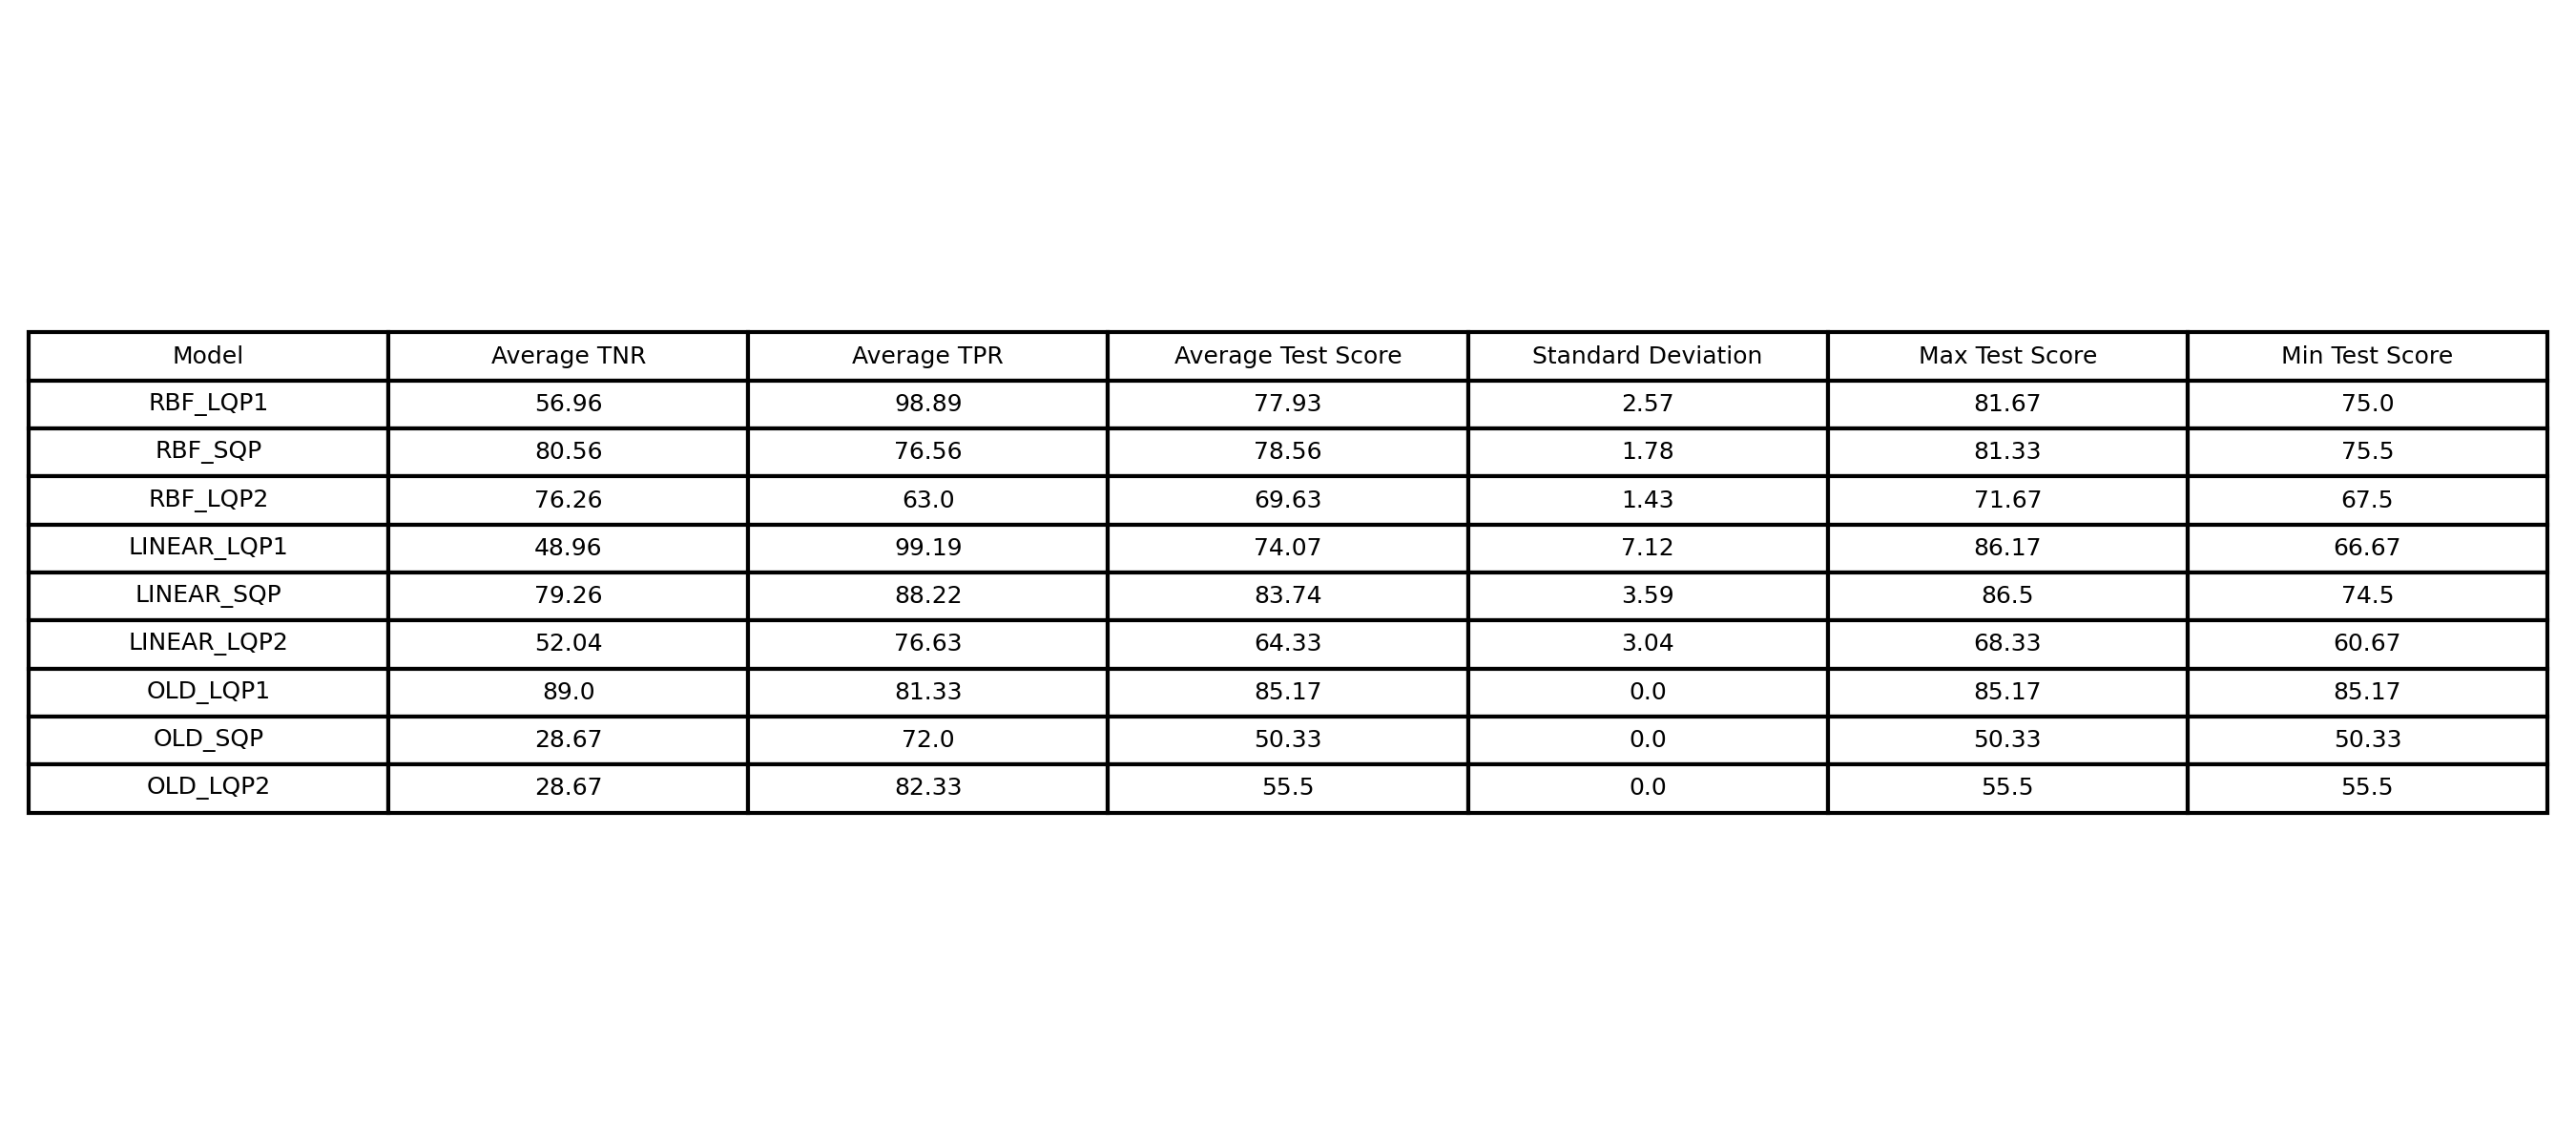

In [18]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 40
plt.rcParams["figure.figsize"] = (10.0, 5.0)
plt.rcParams["figure.dpi"] = 300

# DataFrameをMatplotlibでプロット
plt.axis('off')  # 軸を非表示にする
table = plt.table(cellText=statistics_df.values,
                  colLabels=statistics_df.columns,
                  cellLoc='center', rowLoc='center',
                  loc='center')  # 表の文字サイズを調整

plt.tight_layout()  # レイアウトを調整
plt.savefig('table10.png', bbox_inches="tight", pad_inches=0.0)
plt.show()